In [1]:
import numpy as np
from IPython.display import Image

In [2]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

In [3]:
# Function for initilizing our nn weights and biasis
def init_layers(nn_architecture, seed=101):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}
    
    for idx, layer in enumerate(nn_architecture):
        curr_layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values[f"W{curr_layer_idx}"] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        params_values[f"b{curr_layer_idx}"] = np.random.randn(layer_output_size, 1) * 0.1 # Column vector
        
    return params_values
        

In [4]:
# Activation Functions and their respective dirivatives:

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def sigmoid_gradient(dA, Z):
    # dA is the derivative of the current activation function
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_gradient(dA, Z):
    # dA is the derivative of the current activation function
    dZ = np.array(dA, copy=True)
    # Whichever values are less than or equal to zero have zero gradient
    dZ[Z <= 0] = 0;
    return dZ

Single Layer Forward Propagation:

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$


$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [5]:
# Given the inputs from a previous layer, calculate the next layer

def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        active_fn = relu
    elif activation is "sigmoid":
        active_fn = sigmoid
    else:
        raise Exception("Non-supported activation function")
        
    return active_fn(Z_curr), Z_curr # Why return both values?

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    # Create a temporary memory hash for backwards_prop
    memory = {}
    A_curr = X # X vector is the activation for layer 0
    
    # Iterate over network layers:
    for prev_layer_idx, layer in enumerate(nn_architecture):
        curr_layer_idx = prev_layer_idx + 1
        # Transfer the previous activation into the current layer
        A_prev = A_curr
        
        curr_active_fn = layer["activation"]
        W_curr = params_values[f"W{curr_layer_idx}"]
        b_curr = params_values[f"b{curr_layer_idx}"]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, curr_active_fn)
        
        # The activation of the current layer isn't stored in memory, b/c it is returned directly
        memory[f"A{prev_layer_idx}"] = A_prev
        memory[f"Z{curr_layer_idx}"] = Z_curr
        
    return A_curr, memory

Cross Entropy Cost:
![Cost Function](./assets/cost_function.gif)

In [7]:
def get_cross_entropy_cost(Y_hat, Y):
    m = Y_hat.shape[1] # Number of examples
    # https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#id11
    # https://www.youtube.com/watch?v=mj5DpK5gGsY
    cost = (-1 / m) * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

In [8]:
# Not used by NN, just for reporting
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [9]:
# Not used by NN, just for reporting
def get_accuracy_value(Y_hat, Y):
    _Y_hat = convert_prob_into_class(Y_hat)
    return (Y == _Y_hat).all(axis=0).mean()

In NN, we calculate the gradient of the cost function in respect to parameters, but backpropagation can be used to calculate derivatives of any function. The essence of this algorithm is the recursive use of a chain rule known from differential calculus: calculate a derivative of functions created by assembling other functions, whose derivatives we already know. This process - for one network layer - is described by the following formulas:

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$



In [10]:
def single_layer_backpropagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation):
    """
    Returns dA_dC, dW_dC, and db_dC (all with respect to the cost function)
    """
    # Number of examples:
    m = A_prev.shape[1]
    
    if activation is "relu":
        activation_fn = relu_gradient
    elif activation is "sigmoid":
        activation_fn = sigmoid_gradient
    else:
        raise Exception('Non-supported activation function')
        
    # The gradient Z with respect to the current ativiation
    dZ_curr = activation_fn(dA_curr, Z_curr)
    
    # Partial derivative matrix W with respect to loss
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # Partial derivative of vector b with respect to loss
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # Partial deriviative of the previous layer's activatino func with respect to the loss
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dA_prev, dW_curr, db_curr  

We start by calculating a derivative of the cost function with respect to the prediction vector: the result of forward propagation. This is quite trivial as it only consists of rewriting the following formula. Then iterate through the layers of the network starting from the end and calculate the derivatives with respect to all parameters. Ultimately, function returns a python dictionary containing the gradient we are looking for:

$$\frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$

In [11]:
def full_backpropagation(Y_hat, Y, memory, params_values, nn_architecture):
    """
    Returns a dict of gradients to later apply to each weight and bias
    """
    # Store our gradients in a dictionary for later use
    grads_values = {}
    
    # Number of samples
    m = Y.shape[0]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # Derivative of the cross entropy cost function with respect to the final activation vector (prediction layer)
    dA_prev = -1 * (np.divide(Y, Y_hat) - np.divide((1 - Y), (1 - Y_hat)))
    
    for prev_layer_idx, layer in reversed(list(enumerate(nn_architecture))):
        curr_layer_idx = prev_layer_idx + 1
        curr_activation_fn = layer['activation']

        dA_curr = dA_prev

        A_prev = memory[f"A{prev_layer_idx}"]
        Z_curr = memory[f"Z{curr_layer_idx}"]
        W_curr = params_values[f"W{curr_layer_idx}"]
        b_curr = params_values[f"b{curr_layer_idx}"]

        dA_prev, dW_curr, db_curr = single_layer_backpropagation(
            dA_curr,
            W_curr,
            b_curr,
            Z_curr,
            A_prev,
            curr_activation_fn
        )

        # Store our gradients in a dictionary for later updates
        grads_values[f"dW{curr_layer_idx}"] = dW_curr
        grads_values[f"db{curr_layer_idx}"] = db_curr
    return grads_values

In [12]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    """
    Updates the values in the nn (params_values) according the the gradients and learning rate
    """
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values[f"W{layer_idx}"] -= learning_rate * grads_values[f"dW{layer_idx}"]
        params_values[f"b{layer_idx}"] -= learning_rate * grads_values[f"db{layer_idx}"]
    
    # Not nececary as the function mutates the values
    return params_values

In [13]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    params_values = init_layers(nn_architecture, seed=2)
    
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        # Forward Prop
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        
        cost = get_cross_entropy_cost(Y_hat, Y)
        accuracy = get_accuracy_value(Y_hat, Y)
        
        cost_history.append(cost)
        accuracy_history.append(accuracy)
        
        # Calculate gradient
        grads_values = full_backpropagation(Y_hat, Y, cache, params_values, nn_architecture)
        # Apply gradient
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if i % 50 == 0:
            if verbose:
                print(f"Iteration: {i}, Cost: {cost}, Accuracy: {accuracy}")
            if callback is not None:
                callback(i, params_values)
    
    return params_values

In [14]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

In [15]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

In [16]:
X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [17]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

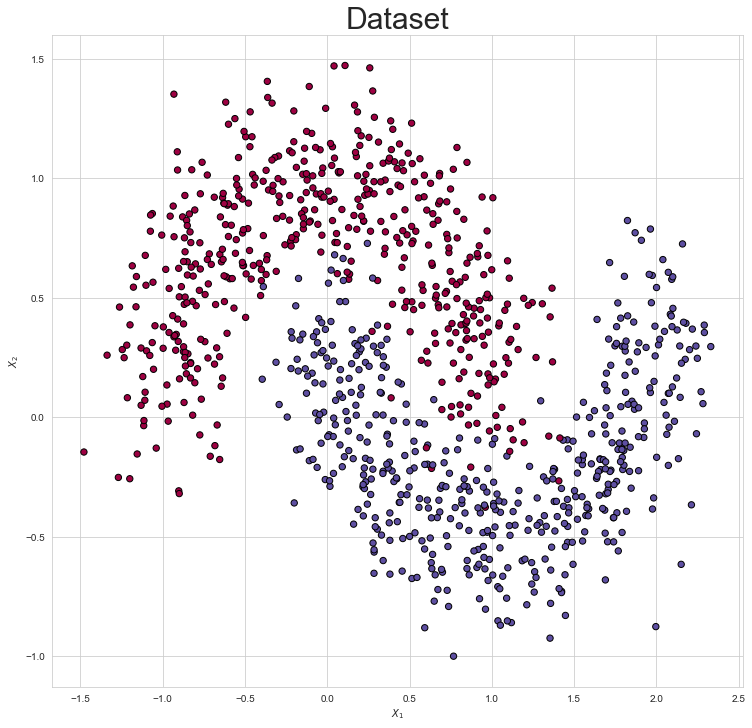

In [18]:
make_plot(X, y, "Dataset")

In [19]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)

In [22]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [23]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.98


In [31]:
(np.ones((25,900)) + np.ones((25, 1))).shape

(25, 900)

In [32]:
np.ones((25, 1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])